# Project 4: Solving the XOR Problem

The inputs are all possible pairs of binary values:
- (0, 0)
- (0, 1)
- (1, 0)
- (1, 1)


The outputs follow the XOR truth table:

1. Output is 1 only when the inputs are different
2. Output is 0 when the inputs are the same


Why Linear Models Fail, and Why Neural Networks Win

The XOR problem is the smallest, cleanest demonstration of why neural networks must be nonlinear. It exposes the fundamental limitation of linear models and shows how hidden layers create new features that make the impossible solvable.

This project introduces:

- nonlinear feature construction
- hidden neurons as feature detectors
- backpropagation through multiple layers
- cross‑entropy loss for classification

By the end, you’ll see a neural network invent the features needed to solve XOR.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# xor dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

## A single‑layer perceptron cannot solve this.
You need:

- a hidden layer
- a nonlinear activation function

## Network Architecture
We build the smallest neural network capable of solving XOR:

- 2 inputs
- 2 hidden neurons
- 1 output neuron

In [2]:
#Initializing the Network Parameters

np.random.seed(42)
hidden_weights = np.random.randn(2, 2)
hidden_biases = np.random.randn(2)

output_weights = np.random.randn(2)
output_bias = np.random.randn()


## What these shapes mean

1. hidden_weights: shape (2, 2) : **2 inputs → 2 hidden neurons**
2. hidden_biases: shape (2) : **One bias per hidden neuron**
3. output_weights: shape (2) : **Takes the 2 hidden activations → 1 output neuron**
4. output_bias: scalar : **Bias for the output neuron**
 
Random initialization ensures each neuron starts differently so they can learn different features.

## Activation Function

Sigmoid introduces the nonlinearity needed to solve XOR

- Sigmoid squashes values into the range (0, 1).
- Its derivative is simple and works well for small networks.

In [3]:
# Activation Function
sigmoid = lambda z: 1 / (1 + np.exp(-z))
sigmoid_deriv = lambda y: y * (1 - y)

## Hyperparameters and Traces

- lr: learning rate
- epochs: number of full passes through the dataset
- loss_history: track training progress
- weight_trace: track how output weights change
- prediction_trace: store predictions over time
- hidden_activation_trace: store hidden neuron activations
- interval: record snapshots every 100 epochs

These traces help visualize how the network learns XOR.


In [4]:
lr = 0.1
epochs = 10000
loss_history = []
weight_trace = []
prediction_trace = defaultdict(list)
hidden_activation_trace = defaultdict(list)
interval = 100

## Full Code for Training Loop Explination Follows!

In [5]:
for epoch in range(epochs):
    total_loss = 0

    for i in range(4):
        x_sample = X[i]
        target_val = y[i]

        # Forward pass: Hidden layer
        z_hidden = hidden_weights @ x_sample + hidden_biases
        hidden_outputs = sigmoid(z_hidden)

        # Forward pass: Output layer
        z_output = output_weights @ hidden_outputs + output_bias
        y_hat = sigmoid(z_output)

        # Cross-Entropy Loss
        eps = 1e-10
        loss = - (target_val * np.log(y_hat + eps) +
                  (1 - target_val) * np.log(1 - y_hat + eps))
        total_loss += loss  

        # Cross-Entropy Output Gradient (simplified)
        dL_dz_output = y_hat - target_val

        # Output layer gradients
        dL_dw_output = dL_dz_output * hidden_outputs
        dL_db_output = dL_dz_output

        # Backprop: Hidden layer
        d_hidden = sigmoid_deriv(hidden_outputs)
        dL_dz_hidden = output_weights * dL_dz_output * d_hidden
        dL_dw_hidden = np.outer(dL_dz_hidden, x_sample)
        dL_db_hidden = dL_dz_hidden

        # Gradient descent update
        output_weights -= lr * dL_dw_output
        output_bias -= lr * dL_db_output
        hidden_weights -= lr * dL_dw_hidden
        hidden_biases -= lr * dL_db_hidden

        weight_trace.append(output_weights.copy())

    # End of epoch
    loss_history.append(total_loss / 4)  # average loss per sample

    if epoch % interval == 0:
        for i in range(4):
            x_sample = X[i]
            z_hidden = hidden_weights @ x_sample + hidden_biases
            hidden_outputs = sigmoid(z_hidden)
            z_output = output_weights @ hidden_outputs + output_bias
            y_pred = sigmoid(z_output)
            prediction_trace[i].append(y_pred)
            hidden_activation_trace[i].append(hidden_outputs.copy())


## Training Loop and Forward Pass

What’s happening here? 

1. Multiply inputs by hidden weights
2. Add hidden biases
3. Apply sigmoid

4. Multiply hidden activations by output weights
5. Add output bias
6. Apply sigmoid again

This produces the network’s prediction **y_hat.**

**This is the same structure as logistic regression — just stacked twice.**

```
for epoch in range(epochs):
    total_loss = 0
    for i in range(4):
        x_sample = X[i]
        target_val = y[i]


        # Forward pass: Hidden layer
        z_hidden = hidden_weights @ x_sample + hidden_biases
        hidden_outputs = sigmoid(z_hidden)


        # Forward pass: Output layer
        z_output = output_weights @ hidden_outputs + output_bias
        y_hat = sigmoid(z_output)
```


## Loss Functions: MSE vs Cross‑Entropy
This is where the project becomes especially educational.

XOR is a classification problem.
The output neuron is a logistic unit.
The correct loss is binary cross‑entropy.

But many beginners start with MSE as I did, so let’s compare them directly.

## Mean Squared Error (MSE)
MSE works, but it fights the sigmoid’s curvature and slows learning.

```
# MSE Loss
loss = 0.5 * (y_hat - target_val) ** 2

# MSE Output Gradient
dL_dyhat = y_hat - target_val
dyhat_dz = sigmoid_deriv(y_hat)
dL_dz_output = dL_dyhat * dyhat_dz

```

**Problems with MSE for classification:**

- gradients vanish when sigmoid saturates
- learning is slower
- optimization landscape is less smooth

## Binary Cross‑Entropy (Recommended)
Cross‑entropy is the mathematically correct loss for probability models.

```
# Cross-Entropy Loss
eps = 1e-10
loss = - (target_val * np.log(y_hat + eps) +
          (1 - target_val) * np.log(1 - y_hat + eps))

# Cross-Entropy Output Gradient (simplified)
dL_dz_output = y_hat - target_val

```

## Why cross‑entropy is better:

- gradient simplifies beautifully
- no sigmoid derivative needed
- faster, more stable learning

matches logistic regression theory

## Side‑by‑Side Comparison
```
Step	  **MSE**	                               **Cross‑Entropy**
Loss	   0.5*(y_hat - y)^2	                -y log(y_hat) - (1-y) log(1-y_hat)
dL/dŷ	    y_hat - y	                         (not needed)
dŷ/dz	   sigmoid_deriv(y_hat)	                (not needed)
dL/dz	   (y_hat - y) * sigmoid_deriv(y_hat)	y_hat - y
Speed	   slower	                            faster
Best for   regression	                        classification
```

## Backpropagation: Output Layer

This computes:
- How much the output changed the loss
- How much the output weights contributed
- How much the output bias contributed

## Output Layer : MSE 

```
dL_dyhat = y_hat - target_val
dyhat_dz = sigmoid_deriv(y_hat)
dL_dz_output = dL_dyhat * dyhat_dz
```

## Output Layer : Cross-Entropy

```dL_dz_output = y_hat - target_val```

### that is the only change

```
dL_dw_output = dL_dz_output * hidden_outputs
dL_db_output = dL_dz_output
```

## Backpropagation: Hidden Layer

- This applies the chain rule:
- The output error flows backward through the output weights
- Each hidden neuron receives part of that error
- Multiply by the derivative of the hidden activation
- Compute gradients for hidden weights and biases

This is the core of backpropagation.

```
d_hidden = sigmoid_deriv(hidden_outputs)
dL_dz_hidden = output_weights * dL_dz_output * d_hidden
dL_dw_hidden = np.outer(dL_dz_hidden, x_sample)
dL_db_hidden = dL_dz_hidden
```


## Gradient Descent Updates

```
output_weights -= lr * dL_dw_output
output_bias -= lr * dL_db_output
hidden_weights -= lr * dL_dw_hidden
hidden_biases -= lr * dL_db_hidden
```
### Each parameter moves a small step in the direction that reduces the loss.

## What the Network Learns

**This is the conceptual payoff.**

1. Hidden neuron 1 typically learns something like:

- OR-ish
- high for (0,1), (1,0), (1,1)
- low for (0,0)

2. Hidden neuron 2 typically learns something like:

- AND-ish not
- high for (1,1)
- low for others

Together, these two nonlinear features form a basis that makes XOR linearly separable.

The output neuron then solves a simple linear classification problem in this new feature space.

This is how neural networks build their own features.

## Visualizing Learning
The four‑panel visualization (loss, weights, predictions, hidden activations):

- loss decreasing
- weights adapting
- predictions converging
- hidden neurons discovering nonlinear structure

This is where the network’s internal geometry becomes visible.

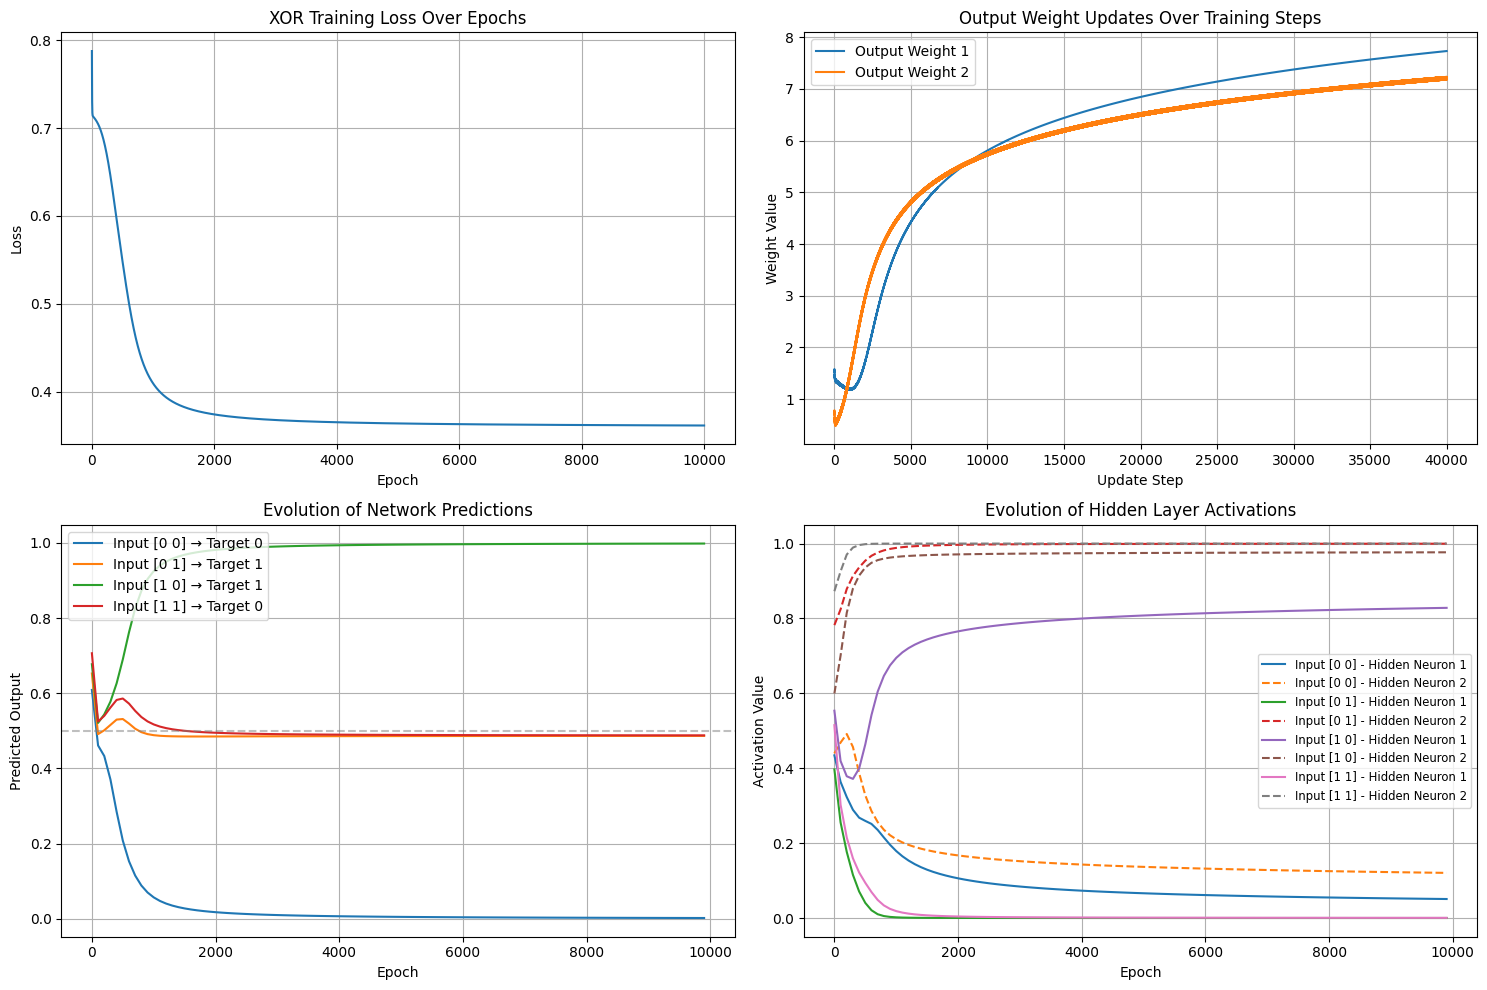

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


# Plot 1: Loss Curve
axs[0, 0].plot(loss_history)
axs[0, 0].set_title("XOR Training Loss Over Epochs")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)


# Plot 2: Output Weight Updates
weight_trace_arr = np.array(weight_trace)
axs[0, 1].plot(weight_trace_arr[:, 0], label='Output Weight 1')
axs[0, 1].plot(weight_trace_arr[:, 1], label='Output Weight 2')
axs[0, 1].legend()
axs[0, 1].set_title("Output Weight Updates Over Training Steps")
axs[0, 1].set_xlabel("Update Step")
axs[0, 1].set_ylabel("Weight Value")
axs[0, 1].grid(True)


# Plot 3: Prediction Evolution
epochs_recorded = np.arange(0, epochs, interval)
for i in range(4):
    axs[1, 0].plot(epochs_recorded, prediction_trace[i],
                   label=f"Input {X[i]} → Target {y[i]}")
axs[1, 0].axhline(0.5, linestyle='--', color='gray', alpha=0.5)
axs[1, 0].set_title("Evolution of Network Predictions")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Predicted Output")
axs[1, 0].legend()
axs[1, 0].grid(True)


# Plot 4: Hidden Layer Activations
for i in range(4):
    activations = np.array(hidden_activation_trace[i])
    axs[1, 1].plot(epochs_recorded, activations[:, 0],
                   label=f"Input {X[i]} - Hidden Neuron 1")
    axs[1, 1].plot(epochs_recorded, activations[:, 1],
                   label=f"Input {X[i]} - Hidden Neuron 2", linestyle='--')
axs[1, 1].set_title("Evolution of Hidden Layer Activations")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Activation Value")
axs[1, 1].legend(fontsize='small')
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()


Project 4 completes the conceptual arc of Section 1:

- linear regression
- multi‑feature regression
- logistic regression
- XOR + hidden layers